In [1]:
import qiskit
from qiskit import QuantumCircuit

import jax.numpy as jnp

import sys
sys.path.append("../../")

from pqcqec.circuits.generate import generate_random_circuit
from pqcqec.circuits.modify import tokenize_qiskit_circuit
from pqcqec.noise.simple_noise import PennylaneNoisyGates
from pqcqec.models.pqc_models import StateInputModelInterleavedPQCModel
from pqcqec.simulate.simulate import run_circuit_with_noise_model, get_input_data
from pqcqec.utils.jax_utils import JAXDataLoader, JAXStateDataset


In [2]:
NUM_QUBITS = 2
NUM_GATES = 2
SEED = 0
GATE_BLOCKS = 2
ZERO_STATE = jnp.zeros((2**NUM_QUBITS,)).at[0].set(1.0)

In [3]:
qiskit_circuit = generate_random_circuit(NUM_QUBITS, NUM_GATES, seed=SEED)

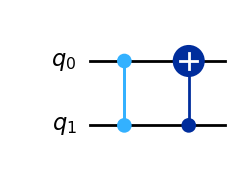

In [4]:
qiskit_circuit.draw('mpl')

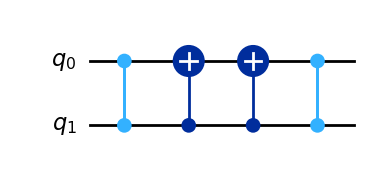

In [5]:
uncomped_circuit = qiskit_circuit.compose(qiskit_circuit.inverse())
uncomped_circuit.draw('mpl')

In [6]:
tokens = tokenize_qiskit_circuit(qiskit_circuit)
print(tokens)
uncomped_circuit_tokens = tokenize_qiskit_circuit(uncomped_circuit)
print(uncomped_circuit_tokens)

[('cz', [1, 0], []), ('cx', [1, 0], [])]
[('cz', [1, 0], []), ('cx', [1, 0], []), ('cx', [1, 0], []), ('cz', [1, 0], [])]


In [7]:
noise_model = PennylaneNoisyGates(seed=SEED)
model = StateInputModelInterleavedPQCModel(uncomped_circuit_tokens, NUM_QUBITS, noise_model=noise_model, pqc_blocks=1, gate_blocks=GATE_BLOCKS, seed=SEED)
model.pqc_params

Array([[[ 2.812775  ,  3.0070062 , -1.0537437 ],
        [-0.19686188,  0.43912372, -2.1017065 ]],

       [[-1.1925825 ,  1.1905414 ,  1.5504801 ],
        [-2.0670767 ,  3.0495682 , -2.9827373 ]]], dtype=float32)

Drawing circuit with params: [[[ 2.812775    3.0070062  -1.0537437 ]
  [-0.19686188  0.43912372 -2.1017065 ]]

 [[-1.1925825   1.1905414   1.5504801 ]
  [-2.0670767   3.0495682  -2.9827373 ]]]
Input state: [1. 0. 0. 0.]
Model: [('cz', [1, 0], []), ('cx', [1, 0], []), ('cx', [1, 0], []), ('cz', [1, 0], [])]


(<Figure size 2200x300 with 1 Axes>, <Axes: >)

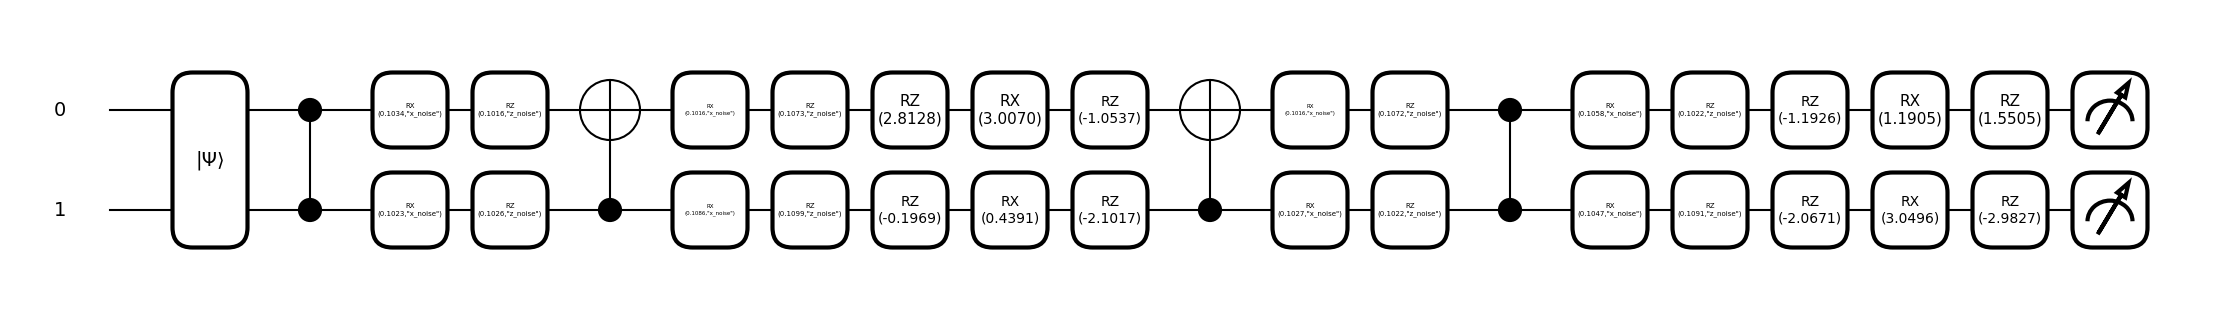

In [8]:
model.draw_mpl(ZERO_STATE)

In [9]:
uncomped_circuit_pqc_tokens = model.get_circuit_tokens()
print(*uncomped_circuit_pqc_tokens, sep='\n')

('cz', [1, 0], [])
('cx', [1, 0], [])
('rz', [0], [2.812774896621704])
('rx', [0], [3.0070061683654785])
('rz', [0], [-1.0537437200546265])
('rz', [1], [-0.1968618780374527])
('rx', [1], [0.4391237199306488])
('rz', [1], [-2.1017065048217773])
('cx', [1, 0], [])
('cz', [1, 0], [])
('rz', [0], [-1.1925824880599976])
('rx', [0], [1.190541386604309])
('rz', [0], [1.5504801273345947])
('rz', [1], [-2.0670766830444336])
('rx', [1], [3.0495681762695312])
('rz', [1], [-2.9827373027801514])


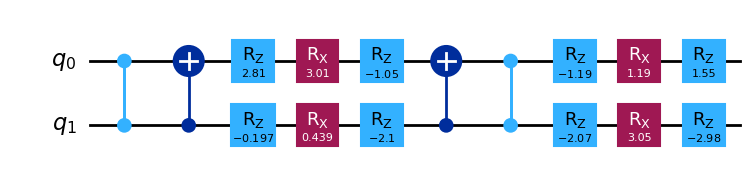

In [10]:
from qiskit import QuantumCircuit

def create_circuit_from_ops(ops_list, num_qubits):
    """
    Creates a Qiskit QuantumCircuit from a list of operations.
    
    Args:
        ops_list (list): List of operations in the format (op, params, qubits).
        num_qubits (int): Number of qubits in the circuit.
    
    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    circuit = QuantumCircuit(num_qubits)
    for op, qubits, params in ops_list:
        if hasattr(circuit, op):
            getattr(circuit, op)(*params, *qubits)
        else:
            raise ValueError(f"Unsupported operation: {op}")
    return circuit

uncomp_pqc_circ = create_circuit_from_ops(uncomped_circuit_pqc_tokens, NUM_QUBITS)
uncomp_pqc_circ.draw('mpl')

In [11]:
from qiskit.qasm2 import dumps

In [12]:
dumps(uncomped_circuit)

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncz q[1],q[0];\ncx q[1],q[0];\ncx q[1],q[0];\ncz q[1],q[0];'

In [13]:
dumps(uncomp_pqc_circ)

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncz q[1],q[0];\ncx q[1],q[0];\nrz(2.812774896621704) q[0];\nrx(3.0070061683654785) q[0];\nrz(-1.0537437200546265) q[0];\nrz(-0.1968618780374527) q[1];\nrx(0.4391237199306488) q[1];\nrz(-2.1017065048217773) q[1];\ncx q[1],q[0];\ncz q[1],q[0];\nrz(-1.1925824880599976) q[0];\nrx(1.190541386604309) q[0];\nrz(1.5504801273345947) q[0];\nrz(-2.0670766830444336) q[1];\nrx(3.0495681762695312) q[1];\nrz(-2.9827373027801514) q[1];'

In [14]:
import math, numpy as np
from qiskit import QuantumCircuit
from typing import List, Tuple, Dict

# --- discretize angles to K bins in [-pi, pi)
def bin_angle(theta: float, K: int = 256) -> int:
    x = (theta + math.pi) % (2*math.pi)
    return int(min(K-1, math.floor(x / (2*math.pi) * K)))

def serialize_gate(name: str, qubits: List[int], params: List[float] | None, K=256) -> List[str]:
    toks = [name]
    if params:
        for p in params:
            toks += ["@p", str(bin_angle(float(p), K))]
    if len(qubits) == 1:
        toks += ["q", str(qubits[0])]
    elif len(qubits) == 2:
        # role-embedded: first as ctrl when applicable
        if name in {"cx", "cz", "cp", "cu", "swap"}:
            toks += ["ctrl", str(qubits[0]), "tgt", str(qubits[1])]
        else:
            toks += ["q", str(qubits[0]), "q", str(qubits[1])]
    else:
        toks += sum([["q", str(q)] for q in qubits], [])
    toks.append(";")
    return toks

def circuit_to_tokens(qc: QuantumCircuit, K: int = 256) -> List[str]:
    toks = []
    for inst, qargs, cargs in qc.data:
        name = inst.name
        params = list(inst.params) if inst.params else []
        qubits = [qb._index for qb in qargs]
        if name == "measure":
            toks += ["measure", "q", str(qubits[0]), "c", str(cargs[0]._index), ";"]
            continue
        toks += serialize_gate(name, qubits, params, K)
    return toks

# Example
qc = QuantumCircuit(2)
qc.rz(0.3, 0); qc.rx(-1.24, 1); qc.cx(0,1); qc.measure_all()
tokens = circuit_to_tokens(qc)
print(tokens[:40])


['rz', '@p', '140', 'q', '0', ';', 'rx', '@p', '77', 'q', '1', ';', 'cx', 'ctrl', '0', 'tgt', '1', ';', 'barrier', 'q', '0', 'q', '1', ';', 'measure', 'q', '0', 'c', '0', ';', 'measure', 'q', '1', 'c', '1', ';']


/var/folders/t2/g8j2h9dd5gj5c2454fz6jz980000gn/T/ipykernel_70153/3465807516.py:30: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:
